In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

data_dir = 'Data/PriceData'

def load_data():
    data_frames = {}
    files = [f for f in os.listdir(data_dir) if f.endswith('.parquet')]
    for file in tqdm(files, desc="Loading Parquet files"):
        ticker = file.split('.')[0]
        df = pd.read_parquet(os.path.join(data_dir, file))
        df['Return'] = df['Close'].pct_change().fillna(method='ffill')
        data_frames[ticker] = df
    return data_frames

def calculate_weighted_returns(data_frames, weights):
    daily_returns = pd.DataFrame({ticker: df['Return'] for ticker, df in data_frames.items()})
    weekly_returns = daily_returns.resample('W').apply(lambda x: (1 + x).prod() - 1)
    monthly_returns = daily_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
    
    weighted_returns = (weights['daily'] * daily_returns +
                        weights['weekly'] * weekly_returns.reindex(daily_returns.index, method='ffill') +
                        weights['monthly'] * monthly_returns.reindex(daily_returns.index, method='ffill'))
    
    return weighted_returns

def cluster_stocks(correlation_matrix):
    scaler = StandardScaler()
    scaled_correlation = scaler.fit_transform(correlation_matrix)
    
    kmeans = KMeans(n_clusters=6, random_state=0, n_init=10)
    clusters = kmeans.fit_predict(scaled_correlation)
    
    return pd.Series(clusters, index=correlation_matrix.index, name='Cluster')

def calculate_cluster_metrics(correlation_matrix, clusters):
    cluster_means = {}
    for cluster in clusters.unique():
        cluster_stocks = clusters[clusters == cluster].index
        cluster_means[cluster] = correlation_matrix.loc[cluster_stocks, cluster_stocks].mean().mean()
    
    return pd.Series(cluster_means)

def calculate_stock_to_cluster_correlations(correlation_matrix, clusters, cluster_means):
    correlations = pd.DataFrame(index=correlation_matrix.index, 
                                columns=[f'correlation_{i}' for i in range(len(cluster_means))])
    
    for cluster in cluster_means.index:
        cluster_stocks = clusters[clusters == cluster].index
        correlations[f'correlation_{cluster}'] = correlation_matrix[cluster_stocks].mean(axis=1)
    
    return correlations

if __name__ == "__main__":
    # Load data
    data_frames = load_data()
    
    # Calculate weighted returns
    weights = {'daily': 0.65, 'weekly': 0.25, 'monthly': 0.10}
    weighted_returns = calculate_weighted_returns(data_frames, weights)
    
    # Calculate correlation matrix
    correlation_matrix = weighted_returns.corr()
    
    # Cluster stocks
    clusters = cluster_stocks(correlation_matrix)
    
    # Calculate cluster metrics
    cluster_means = calculate_cluster_metrics(correlation_matrix, clusters)
    
    # Calculate stock-to-cluster correlations
    stock_cluster_correlations = calculate_stock_to_cluster_correlations(correlation_matrix, clusters, cluster_means)
    
    # Prepare final DataFrame
    result = pd.DataFrame({
        'Ticker': correlation_matrix.index,
        'Cluster': clusters
    })
    result = result.join(stock_cluster_correlations)
    result['mean_intragroup_correlation'] = result['Cluster'].map(cluster_means)
    result['diff_to_mean_group_corr'] = result.apply(
        lambda row: row[f'correlation_{row.Cluster}'] - row['mean_intragroup_correlation'], axis=1)
    
    # Reorder columns
    reordered_columns = (['Ticker', 'Cluster', 'mean_intragroup_correlation', 'diff_to_mean_group_corr'] + 
                         [col for col in result.columns if col.startswith('correlation_')])
    result = result[reordered_columns].round(5)
    
    # Save results
    result.to_parquet('Correlations.parquet', index=False)
    print("Correlations saved to 'Correlations.parquet'.")

Elbow Method: 100%|██████████| 18/18 [01:44<00:00,  5.79s/it]


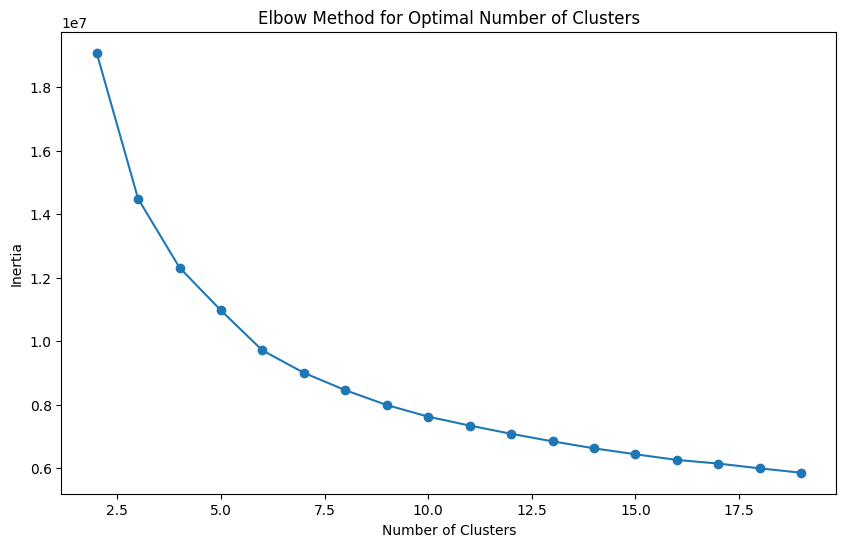

Silhouette Score: 100%|██████████| 18/18 [01:52<00:00,  6.27s/it]


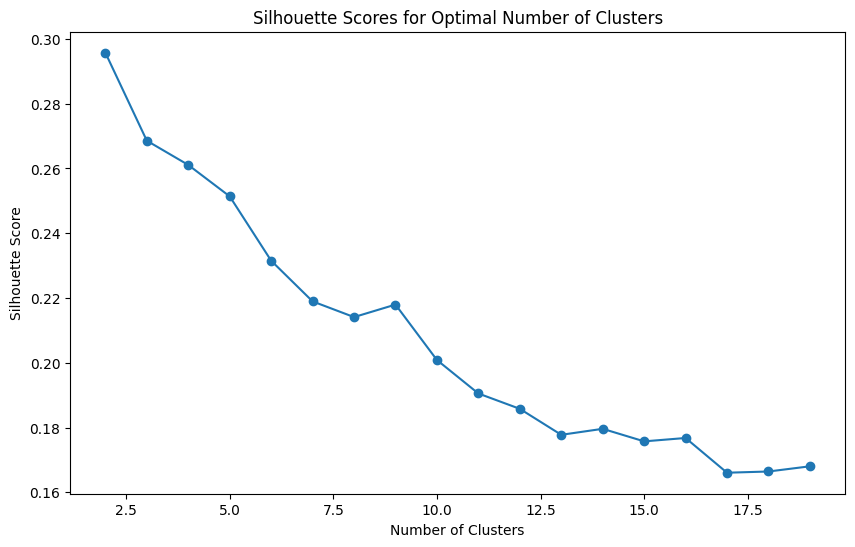

Calculating Group Correlations: 100%|██████████| 8/8 [00:00<00:00, 173.83it/s]


      Ticker  Cluster
0       AACG        6
1       AACI        7
2       AADI        6
3       AAGR        3
4        AAL        1
5       AAMC        7
6       AAME        6
7        AAN        6
8       AAOI        0
9       AAON        0
10       AAP        6
11      AAPL        2
12       AAT        1
13        AB        1
14      ABAT        2
15      ABBV        3
16      ABCB        1
17      ABCL        3
18      ABEO        0
19      ABEV        4
20       ABG        6
21      ABIO        0
22       ABL        3
23       ABM        1
24      ABNB        5
25      ABOS        0
26       ABR        1
27      ABSI        0
28       ABT        2
29      ABUS        6
30        AC        4
31       ACA        0
32      ACAB        7
33      ACAC        7
34      ACAD        7
35      ACBA        7
36      ACCD        2
37      ACCO        5
38      ACDC        6
39      ACEL        1
40      ACET        3
41      ACGL        7
42      ACHC        6
43      ACHL        0
44      AC

In [4]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from numba import njit

data_dir = 'Data/PriceData'

# Load Parquet files into data_frames dictionary
data_frames = {}
files = [file for file in os.listdir(data_dir) if file.endswith('.parquet')]
for file in tqdm(files, desc="Loading Parquet files"):
    ticker = file.split('.')[0]
    data_frames[ticker] = pd.read_parquet(os.path.join(data_dir, file))

@njit
def calculate_dynamic_weights(volatility, mean_volatility, std_volatility):
    if std_volatility == 0:
        return np.array([0.25, 0.25, 0.25, 0.25])
    
    z_score = (volatility - mean_volatility) / std_volatility
    weights = np.array([0.25 - 0.1*z_score, 0.25 - 0.05*z_score, 0.25 + 0.05*z_score, 0.25 + 0.1*z_score])
    weights = np.maximum(np.minimum(weights, 1), 0)  # This replaces np.clip
    return weights / np.sum(weights)

@njit
def calculate_weighted_returns_fast(returns, volatility, mean_volatility, std_volatility):
    weighted_returns = np.zeros(len(returns))
    for i in range(21, len(returns)):
        weights = calculate_dynamic_weights(volatility[i], mean_volatility[i], std_volatility[i])
        weighted_returns[i] = np.sum(returns[i] * weights)
    return weighted_returns

def process_stock_data(df):
    df['Daily_Return'] = df['Close'].pct_change().fillna(method='bfill').round(3)
    df['Weekly_Return'] = df['Close'].pct_change(5).fillna(method='bfill').round(3)
    df['Monthly_Return'] = df['Close'].pct_change(21).fillna(method='bfill').round(3)
    df['Yearly_Return'] = df['Close'].pct_change(252).fillna(method='bfill').round(3)

    df['Volatility'] = df['Daily_Return'].rolling(window=21).std().fillna(method='bfill')
    df['Mean_Volatility'] = df['Volatility'].rolling(window=21).mean().fillna(method='bfill')
    df['Volatility_Std'] = df['Volatility'].rolling(window=21).std().fillna(method='bfill')

    returns = np.column_stack((df['Daily_Return'], df['Weekly_Return'], df['Monthly_Return'], df['Yearly_Return']))
    volatility = df['Volatility'].values
    mean_volatility = df['Mean_Volatility'].values
    std_volatility = df['Volatility_Std'].values

    df['Weighted_Return'] = calculate_weighted_returns_fast(returns, volatility, mean_volatility, std_volatility)
    df['Weighted_Return'] = df['Weighted_Return'].round(3)

    return df

# Process all stocks
for ticker, df in tqdm(data_frames.items(), desc="Processing stocks"):
    data_frames[ticker] = process_stock_data(df)

returns_df = pd.DataFrame({ticker: df['Weighted_Return'] for ticker, df in data_frames.items()}).fillna(method='bfill')

correlation_matrix = returns_df.corr().fillna(method='bfill').fillna(method='ffill')

scaler = StandardScaler()
scaled_correlation = scaler.fit_transform(correlation_matrix)

# Perform clustering
kmeans = KMeans(n_clusters=8, random_state=0, n_init=10)
clusters = kmeans.fit_predict(scaled_correlation)

correlation_matrix_df = pd.DataFrame(correlation_matrix)
correlation_matrix_df['Cluster'] = clusters

# Elbow Method
inertia = []
for k in tqdm(range(2, 20), desc="Elbow Method"):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(scaled_correlation)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Silhouette Score
silhouette_scores = []
for k in tqdm(range(2, 20), desc="Silhouette Score"):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = kmeans.fit_predict(scaled_correlation)
    silhouette_scores.append(silhouette_score(scaled_correlation, labels))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Optimal Number of Clusters')
plt.show()

clustered_assets = correlation_matrix_df[['Cluster']].reset_index()
clustered_assets.columns = ['Ticker', 'Cluster']

def calculate_group_correlations_vectorized(correlation_matrix, clustered_assets):
    corr_array = correlation_matrix.values
    unique_clusters = clustered_assets['Cluster'].unique()
    cluster_indices = {cluster: clustered_assets.index[clustered_assets['Cluster'] == cluster].tolist() 
                       for cluster in unique_clusters}
    
    result = pd.DataFrame(index=correlation_matrix.index, 
                          columns=[f'correlation_{cluster}' for cluster in unique_clusters])
    
    for cluster in tqdm(unique_clusters, desc="Calculating Group Correlations"):
        indices = cluster_indices[cluster]
        cluster_correlations = corr_array[:, indices].mean(axis=1)
        result[f'correlation_{cluster}'] = cluster_correlations
    
    return result

group_correlations = calculate_group_correlations_vectorized(correlation_matrix, clustered_assets)

clustered_assets = clustered_assets.merge(group_correlations, left_on='Ticker', right_index=True)

mean_intra_group_corr = clustered_assets.groupby('Cluster')[group_correlations.columns].mean().mean(axis=1)
clustered_assets['mean_intragroup_correlation'] = clustered_assets['Cluster'].map(mean_intra_group_corr)
clustered_assets['diff_to_mean_group_corr'] = clustered_assets.apply(
    lambda row: row[f'correlation_{row.Cluster}'] - row['mean_intragroup_correlation'], axis=1)

reordered_columns = ['Ticker', 'Cluster', 'mean_intragroup_correlation', 'diff_to_mean_group_corr'] + list(group_correlations.columns)
clustered_assets = clustered_assets[reordered_columns].round(5)

clustered_assets.to_parquet('Correlations.parquet', index=False)

pd.set_option('display.max_rows', None)
print(clustered_assets[['Ticker', 'Cluster']])

print("Correlations saved to 'Correlations.parquet'.")